# SETS

A counterfactual explanation, originally introduced to machine learning by [1], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

Shapelet-based Temporal Association Rule Mining for Multivariate Time Series Classification developed by Bahri et al. [1] builds counterfactuals in multivariate setting by perturbing the features of a time series with the help of a shapelet algorithm. Hereby they extract the most prominent class shapelets using an adaption of the shapelet transform algorithm of [2] implemented in sktime. The algorithm is adapted to multivariate timeseries analysis, treating each dimension as a univariate timeseries and information gain. The algorithm imputes the shapelets based on prior observed occcurences and shapelet quality. If a single shapelet does not cause a counterfactual prediction, more perturbations in other dimensions or other parts of the timeseries are performed. 


<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/SETS_CF.png" alt="Visualization of SETS_CF" style="width: 800px;" />



Visualization of SETS from the original paper [1]; The code in TSInterpret is based on the authors <a href='https://github.com/omarbahri/SETS'>implementation </a>.

[1] Omar Bahri and Soukaina Filali Boubrahimi and Shah Muhammad Hamdi.Shapelet-Based Counterfactual Explanations for Multivariate Time Series. 2022 ACM SIGKDD Workshop on Mining and Learning from Time Series. arXiv:2208.10462 URL:https://arxiv.org/abs/2208.10462 (visited on 2023-12-04)


[2] Hills, Jon and Lines, Jason and Baranauskas, Edgaras and Mapp, James and Bagnall, Anthony. Classification of time series by shapelet transformation. Data Mining and Knowledge Discovery. Harv. JL & Tech. 31 (2017): 841.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')
import pickle
import sklearn

## Load Data and Model
- Load Data and reshape the data to fit a 1D-Conv Convolutional Neural Network (CNN). Note that the input for a 1D-Conv CNN hat the shape (batch, timesteps, features).
- Load Model with Pretrained Weigths. 

In [2]:
dataset='GunPoint'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=np.swapaxes(X_train,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=np.swapaxes(X_test,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
#enc1=pickle.load(open(f'../../ClassificationModels//models/{dataset}/OneHotEncoder.pkl','rb'))
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
#test_y=enc1.transform(test_y.reshape(-1,1))
#train_y=enc1.transform(train_y.reshape(-1,1))
n_classes = len(np.unique(test_y))



In [3]:
n_classes

2

In [4]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds, fit
stride = 1
kernel_size=10
padding = kernel_size - 1
input_size= train_x.shape[-1]
device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels= 1, num_pred_classes=n_classes)

model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
#torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)
model.eval()
y_pred,labels= get_all_preds(model,test_loader)


## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

### 1. & 2. Loading & Initialization

SETS works on all models returning a probability function. The Initialization takes the following arguments:

    `model`: The model to be explaines.
    `data`: Tuple of Data and Labels.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: Optimization Method either `brut` or `opt`.
    `min_shapelet_len` : Value for min length of extracted shapelets 
    `max_shapelet_len`: Value for max length of extracted shapelets
    `time_contract_in_mins_per_dim` : Max time for shapelet extraction per dimension
    `initial_num_shapelets_per_case` : Initial number of shapelets per case.

### For Univariate ECG200 Case

In [5]:
%load_ext autoreload
%autoreload 2

from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF

#train_x, train_y, test_x, test_y = X_train,train_y,X_test,test_y

# Note: this is for demonstration purposes, time contract per minutes should be adjusted for better results! 
exp_model= SETSCF(model,
                  (train_x, train_y),
                  backend='PYT',
                  mode='feat',  
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False )


(50, 1, 150)
(50, 1)
Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


In [6]:
train_x.shape

(50, 1, 150)

### 3. Call the fit method.

This method is optional! If shapelets are already exctracted, please specify here the occlusion threshhold and if shapelets belonging to multiple classes should be retained. 
This method is called by default if the explain_model is fitted. 


In [7]:
exp_model.fit(occlusion_threshhold=1e-1,remove_multiclass_shapelets=True)


Fit function to prune shapelets with occlusion threshhold of 0.1 and remove shapelets belonging to more than one class set to True
Shapelet by index per class and dimension: {0: [[0, 1, 3, 5, 7, 8, 11, 13, 15, 18]], 1: [[2, 4, 6, 9, 10, 12, 14, 16, 17]]}



### 4. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained

In [10]:
ts = 1
test_y[ts]
print('ts',y_pred[ts])
cf_explanation, label = exp_model.explain(test_x[ts], target = 1)

ts 0
{0: KNeighborsTimeSeries(n_neighbors=1), 1: KNeighborsTimeSeries(n_neighbors=1)}
0
Could not find a cf for this timeseries


### 4. Visualization

All plot function take as input the item to be explained and the returned explanation. As as additonal option a figsize can be given.


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

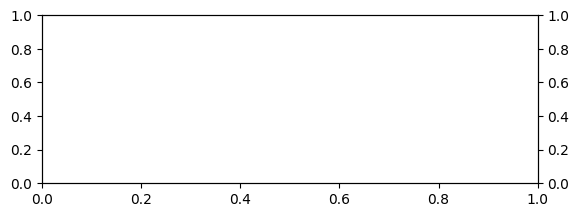

In [9]:
exp_model.plot(
        test_x[ts],
        y_pred[ts],
        cf_explanation,
        label,
        vis_change=True,
        all_in_one=False,
        save_fig=None,
        figsize=(6.4, 4.8))

### Multivariate Case

In [ ]:
import sklearn
dataset='BasicMotions'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=np.swapaxes(X_train,2,1)
test_x=np.swapaxes(X_test,2,1)


n_classes = len(np.unique(test_y))


In [ ]:
n_classes

4

In [ ]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds
from ClassificationModels.LSTM_T import LSTM

#device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels=train_x.shape[1], num_pred_classes=n_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels//models/{dataset}/ResNet'))
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)

In [ ]:
np.argmax(model(torch.from_numpy(test_x).float()).detach().numpy(),axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(6, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(6, 64, kernel_size=(1,)

In [ ]:
y_pred=model(torch.from_numpy(train_x).float()).detach().numpy()
train_y=np.argmax(y_pred,axis=1)


In [ ]:
%load_ext autoreload
%autoreload 2

from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF
exp_model= SETSCF(model,
                  (train_x,train_y),
                  backend='PYT',
                  mode='feat',         
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(40, 6, 100)
(40, 6)
Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


In [ ]:
exp_model.fit(occlusion_threshhold=3e-1,remove_multiclass_shapelets=False)

Fit function to prune shapelets with occlusion threshhold of 0.3 and remove shapelets belonging to more than one class set to False
Shapelet by index per class and dimension: {0: [[0, 1, 18, 19, 23, 24, 25, 28, 29, 30, 31, 34, 35, 36, 39, 41, 42, 44, 50, 60, 65, 67], [0, 1, 2, 26, 29, 30, 32, 33, 35, 36, 42, 44, 48, 49, 54], [0, 5, 8, 15, 16, 18, 20, 21, 32, 34, 36, 41, 43, 50, 55], [10, 11, 18, 22, 23, 24, 28, 31, 33, 34, 40, 54, 55], [3, 8, 10, 14, 19, 20, 21, 22, 25, 36, 37, 40, 43], [0, 1, 2, 3, 4, 5, 20, 23, 24, 28, 29, 32]], 1: [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 26, 58], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 31, 50], [12, 19, 22, 23, 25, 31, 42, 44, 45, 48, 52, 53, 56, 57], [0, 2, 3, 4, 5, 7, 13, 14, 17, 19, 26, 29, 44], [0, 4, 5, 9, 11, 13, 15, 23, 30, 38, 42, 45], [6, 7, 8, 15, 16, 17, 21, 26, 27, 31]], 2: [[43, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 59, 61, 63], [34, 37, 38, 39, 43, 45, 46, 47, 51, 53, 55, 56, 57, 59], [9, 13, 26, 28, 29, 33, 38, 46, 47, 49

In [ ]:
ts = 4
cf_explanation, label = exp_model.explain(train_x[ts]
                                     )

2
Could not find a cf for this timeseries


In [ ]:
np.argmax(y_pred,axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#item, org_label, exp, cf_label, save_fig=None, figsize=(6.4, 4.8)
exp_model.plot_in_one(train_x[ts],np.argmax(y_pred[ts]),cf_explanation,label,figsize=(15,15))

Items are identical
